Deep Learning
=============

Assignment 6
------------

After training a skip-gram model in `5_word2vec.ipynb`, the goal of this notebook is to train a LSTM character model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve

from tensorflow.python.ops.math_ops import tanh
from tensorflow.python.ops import array_ops

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
def read_data(filename):
  f = zipfile.ZipFile(filename)
  for name in f.namelist():
    return tf.compat.as_str(f.read(name))
  f.close()
  
text = read_data(filename)
print('Data size %d' % len(text))

Data size 100000000


Create a small validation set.

In [4]:
valid_size = 1000
valid_text = text[:valid_size]
train_text = text[valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99999000 ons anarchists advocate social relations based upon voluntary as
1000  anarchism originated as a term of abuse first used against earl


Utility functions to map characters to vocabulary IDs and back.

In [5]:
vocabulary_size = len(string.ascii_lowercase) + 1 # [a-z] + ' '
first_letter = ord(string.ascii_lowercase[0])

def char2id(char):
  if char in string.ascii_lowercase:
    return ord(char) - first_letter + 1
  elif char == ' ':
    return 0
  else:
    print('Unexpected character: %s' % char)
    return 0
  
def id2char(dictid):
  if dictid > 0:
    return chr(dictid + first_letter - 1)
  else:
    return ' '

print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(0))

Unexpected character: ï
1 26 0 0
a z  


Function to generate a training batch for the LSTM model.

In [6]:
batch_size=64
num_unrollings=10

In [7]:
class BatchGenerator(object):
  def __init__(self, text, batch_size, num_unrollings):
    self._text = text
    self._text_size = len(text)
    self._batch_size = batch_size
    self._num_unrollings = num_unrollings
    segment = self._text_size // batch_size
    self._cursor = [ offset * segment for offset in range(batch_size)]
    self._last_batch = self._next_batch()
  
  def _next_batch(self):
    """Generate a single batch from the current cursor position in the data."""
    batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
    for b in range(self._batch_size):
      batch[b, char2id(self._text[self._cursor[b]])] = 1.0
      self._cursor[b] = (self._cursor[b] + 1) % self._text_size
    return batch
  
  def next(self):
    """Generate the next array of batches from the data. The array consists of
    the last batch of the previous array, followed by num_unrollings new ones.
    """
    batches = [self._last_batch]
    for step in range(self._num_unrollings):
      batches.append(self._next_batch())
    self._last_batch = batches[-1]
    return batches

def characters(probabilities):
  """Turn a 1-hot encoding or a probability distribution over the possible
  characters back into its (most likely) character representation."""
  return [id2char(c) for c in np.argmax(probabilities, 1)]

def batches2string(batches):
  """Convert a sequence of batches back into their (most likely) string
  representation."""
  s = [''] * batches[0].shape[0]
  for b in batches:
    s = [''.join(x) for x in zip(s, characters(b))]
  return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

['ons anarchi', 'when milita', 'lleria arch', ' abbeys and', 'married urr', 'hel and ric', 'y and litur', 'ay opened f', 'tion from t', 'migration t', 'new york ot', 'he boeing s', 'e listed wi', 'eber has pr', 'o be made t', 'yer who rec', 'ore signifi', 'a fierce cr', ' two six ei', 'aristotle s', 'ity can be ', ' and intrac', 'tion of the', 'dy to pass ', 'f certain d', 'at it will ', 'e convince ', 'ent told hi', 'ampaign and', 'rver side s', 'ious texts ', 'o capitaliz', 'a duplicate', 'gh ann es d', 'ine january', 'ross zero t', 'cal theorie', 'ast instanc', ' dimensiona', 'most holy m', 't s support', 'u is still ', 'e oscillati', 'o eight sub', 'of italy la', 's the tower', 'klahoma pre', 'erprise lin', 'ws becomes ', 'et in a naz', 'the fabian ', 'etchy to re', ' sharman ne', 'ised empero', 'ting in pol', 'd neo latin', 'th risky ri', 'encyclopedi', 'fense the a', 'duating fro', 'treet grid ', 'ations more', 'appeal of d', 'si have mad']
['ists advoca', 'ary governm', 'hes nat

In [8]:
def logprob(predictions, labels):
  """Log-probability of the true labels in a predicted batch."""
  predictions[predictions < 1e-10] = 1e-10
  return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

def sample_distribution(distribution):
  """Sample one element from a distribution assumed to be an array of normalized
  probabilities.
  """
  r = random.uniform(0, 1)
  s = 0
  for i in range(len(distribution)):
    s += distribution[i]
    if s >= r:
      return i
  return len(distribution) - 1

def sample(prediction):
  """Turn a (column) prediction into 1-hot encoded samples."""
  p = np.zeros(shape=[1, vocabulary_size], dtype=np.float)
  p[0, sample_distribution(prediction[0])] = 1.0
  return p

def random_distribution():
  """Generate a random column of probabilities."""
  b = np.random.uniform(0.0, 1.0, size=[1, vocabulary_size])
  return b/np.sum(b, 1)[:,None]

Simple LSTM Model.

In [9]:
num_nodes = 64

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  ix = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ib = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  fx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  fb = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  cx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  ox = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ob = tf.Variable(tf.zeros([1, num_nodes]))
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Definition of the cell computation.
  def lstm_cell(i, o, state):

    ic = tf.matmul(i, array_ops.concat(concat_dim=1, values=[ix,fx,cx,ox]))
    oc = tf.matmul(o, array_ops.concat(concat_dim=1, values=[im,fm,cm,om]))
    
    iix, ifx, icx, iox = array_ops.split(1, 4, ic)
    oim, ofm, ocm, oom = array_ops.split(1, 4, oc)
    
    input_gate = tf.sigmoid(iix + oim + ib)
    forget_gate = tf.sigmoid(ifx + ofm + fb)
    output_gate = tf.sigmoid(iox + oom + ob)
    
    update = icx + ocm + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    
    return output_gate * tf.tanh(state), state

  # Input data.
  train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
  train_inputs = train_data[:num_unrollings]
  train_labels = train_data[1:]  # labels are inputs shifted by one time step.

  # Unrolled LSTM loop.
  outputs = list()
  output = saved_output
  state = saved_state
  for i in train_inputs:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(0, outputs), w, b)
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
        logits, tf.concat(0, train_labels)))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  
  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

In [10]:
num_steps = 9001
summary_frequency = 100

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(batches)[1:])
      print('Minibatch perplexity: %.2f' % float(np.exp(logprob(predictions, labels))))
    
      #print (predictions.shape, predictions)
      #print (labels.shape, labels)
      if step % (summary_frequency * 10) == 0:
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          feed = sample(random_distribution())
          sentence = characters(feed)[0]
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({sample_input: feed})
            feed = sample(prediction)
            sentence += characters(feed)[0]
          print(sentence)
        print('=' * 80)
      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      for _ in range(valid_size):
        b = valid_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, b[1])
      print('Validation set perplexity: %.2f' % float(np.exp(
        valid_logprob / valid_size)))

Initialized
Average loss at step 0: 3.294579 learning rate: 10.000000
Minibatch perplexity: 26.97
u lrpfmemgc c xr mnn  ihioo tetrioteveifn  hip ijd fn qmegfxiub rzsidbvrjpzcnnre
ljh  jpla  tvhcwxa  uuz   a ecmm skztiusngvbsocrbscf grnucgjo giuotmnf mldre on 
ravf  eraens  mjdalss pabfdzaq  hcu rflkrn chvuc deayhtyehfcboo fcxzucqabea ek f
sova e t  vdendiowsnczts fgeojhlid we  tregpih pl rrakfa pvkug f cqccia  jtuhbgw
vt e xapog hlehgxqwalajiw vcfcfaareohovdtf itexyibxa nxdxtjfpizraqmcyttnntu ekia
Validation set perplexity: 20.31
Average loss at step 100: 2.584798 learning rate: 10.000000
Minibatch perplexity: 10.93
Validation set perplexity: 10.27
Average loss at step 200: 2.242994 learning rate: 10.000000
Minibatch perplexity: 8.49
Validation set perplexity: 8.42
Average loss at step 300: 2.100955 learning rate: 10.000000
Minibatch perplexity: 7.38
Validation set perplexity: 7.93
Average loss at step 400: 1.998445 learning rate: 10.000000
Minibatch perplexity: 7.42
Validation set per

---
Problem 1
---------

You might have noticed that the definition of the LSTM cell involves 4 matrix multiplications with the input, and 4 matrix multiplications with the output. Simplify the expression by using a single matrix multiply for each, and variables that are 4 times larger.

---

In [ ]:
def my_lstm_cell(i, o, state):

    ic = tf.matmul(i, array_ops.concat(concat_dim=1, values=[ix,fx,cx,ox]))
    oc = tf.matmul(o, array_ops.concat(concat_dim=1, values=[im,fm,cm,om]))
    
    iix, ifx, icx, iox = array_ops.split(1, 4, ic)
    oim, ofm, ocm, oom = array_ops.split(1, 4, oc)
    
    input_gate = tf.sigmoid(iix + oim + ib)
    forget_gate = tf.sigmoid(ifx + ofm + fb)
    output_gate = tf.sigmoid(iox + oom + ob)
    
    update = icx + ocm + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    
    return output_gate * tf.tanh(state), state

---
Problem 2
---------

We want to train a LSTM over bigrams, that is pairs of consecutive characters like 'ab' instead of single characters like 'a'. Since the number of possible bigrams is large, feeding them directly to the LSTM using 1-hot encodings will lead to a very sparse representation that is very wasteful computationally.

a- Introduce an embedding lookup on the inputs, and feed the embeddings to the LSTM cell instead of the inputs themselves.

b- Write a bigram-based LSTM, modeled on the character LSTM above.

c- Introduce Dropout. For best practices on how to use Dropout in LSTMs, refer to this [article](http://arxiv.org/abs/1409.2329).

---

In [11]:
%matplotlib inline

from sklearn.metrics.pairwise import cosine_similarity
from itertools import compress
from IPython import display
from nltk import bigrams

import matplotlib.pyplot as plt
import collections
import math

def bigram(text, overlap=False):
    """Convert a string of text to a list of bigrams"""
    bg = bigrams(text)
    if overlap: return [''.join(t) for t in bg]
    else: return [''.join(t) for i, t in enumerate(bg) if i%2==0]

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [12]:
bg = bigram(text)
print(len(bg))

50000000


In [11]:
bg[:13]

[' a', 'na', 'rc', 'hi', 'sm', ' o', 'ri', 'gi', 'na', 'te', 'd ', 'as', ' a']

In [13]:
voc_size = 75000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(voc_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

datum, count, dictionary, reverse_dictionary = build_dataset(bg)
voc_size = len(dictionary)

print('Dictionary size:', voc_size)
print('Most common words (+UNK)', count[:5])
print('Sample data', datum[:10])

data_index = 0

Dictionary size: 729
Most common words (+UNK) [['UNK', 0], ('e ', 1843425), (' t', 1224131), ('s ', 1111188), ('th', 990343)]
Sample data [5, 96, 220, 75, 267, 10, 56, 196, 96, 29]


In [14]:
def generate_batch_skipgram(dat, batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span) # used for collecting data[data_index] in the sliding window
    for _ in range(span):
            buffer.append(dat[data_index])
            data_index = (data_index + 1) % len(dat)
    for i in range(batch_size // num_skips):
            target = skip_window  # target label at the center of the buffer
            targets_to_avoid = [ skip_window ]
            for j in range(num_skips):
                while target in targets_to_avoid:
                    target = random.randint(0, span - 1)
                targets_to_avoid.append(target)
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j, 0] = buffer[target]
            buffer.append(dat[data_index])
            data_index = (data_index + 1) % len(dat)
    return batch, labels

In [15]:
architecture = 'SKIP'

batch_size = 512
embedding_size = 64 # Dimension of the embedding vector.
skip_window = 4 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.

valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

if architecture == 'CBOW':
    input_shape = [batch_size, num_skips]
    generate_batch = generate_batch_cbow
elif architecture == 'SKIP':
    input_shape = [batch_size]
    generate_batch = generate_batch_skipgram


graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=input_shape)
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([voc_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([voc_size]))
  
  if architecture == 'SKIP':
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    
  elif architecture == 'CBOW':
    emb = tf.zeros([batch_size, embedding_size])
    for j in range(num_skips):
        emb += tf.nn.embedding_lookup(embeddings, train_dataset[:, j])
    embed = emb

  loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                                                   train_labels, num_sampled, voc_size))  

  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Average loss at step 50000: 3.821967


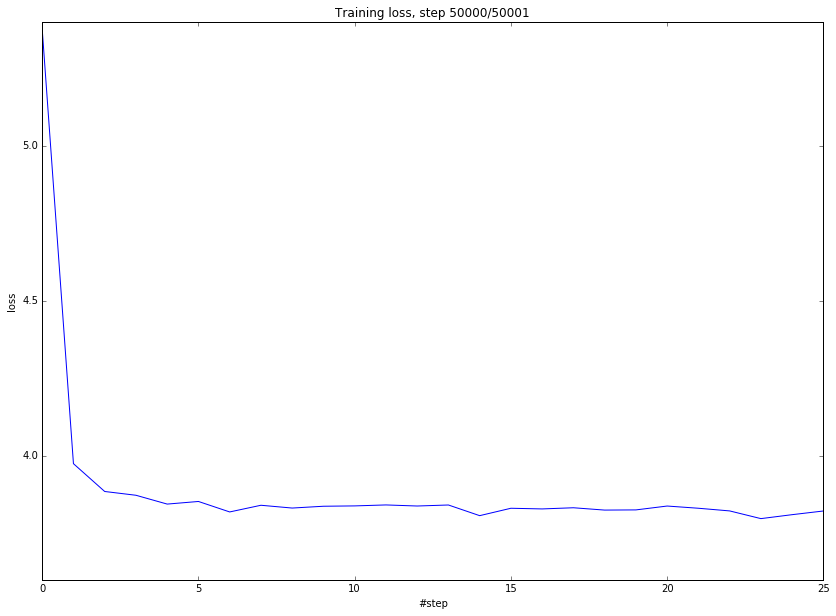

Nearest to es: ns, bv, gq, ep, oj, ed, ms, zb,
Nearest to si: qf, xz, kj, sn, xr, kx, mc, mo,
Nearest to  h: yj, sz, nw,  w, zy, gp,  d, eh,
Nearest to l : c , kp, fn, mk, a , wk, n , d ,
Nearest to om: am, jn, ol, ym, ko, im, sv, ap,
Nearest to el: zf, eg, ua, tv, il,  d, ec, wj,
Nearest to  r:  d, tk, vf, pb, xd, cc, zq, pr,
Nearest to fi: ze, pe, tk, ni, us, tl, fe, no,
Nearest to  i: qs, jy, fx, yu, xf, za,  c, ha,
Nearest to  b: nl, pb, tl, vy, kx,  m, ll, dc,
Nearest to ca: ga, vo, gi, lx, co, na, vv, ve,
Nearest to en: ih, nm, mz, pk, jz, qr, dj, tq,
Nearest to  a: sn, pz, xm, xp, oy, lz, oe, ef,
Nearest to UNK: go, su, cu, wr, fs, jl, qp, lv,
Nearest to  p:  v,  c,  g, wm,  m, kc, ep, yi,
Nearest to ar: os, rf, uv, ag, rl, la, cg, oj,


In [16]:
num_steps = 50001
lh = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
        
    batch_data, batch_labels = generate_batch(datum, batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    
    average_loss += l
    
    if step % 2000 == 0:
      display.clear_output(wait=True)
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      lh.append(average_loss)
      average_loss = 0
            
      plt.figure(figsize=(14, 10))

      plt.title("Training loss, step {}/{}".format(step, num_steps))
      plt.xlabel("#step")
      plt.ylabel("loss")
      plt.plot(lh, 'b')
      plt.show()
      

    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
        
  final_embeddings = normalized_embeddings.eval()

In [17]:
import cPickle as pkl

In [18]:
BI_EMB = final_embeddings

In [19]:
with open('BIEMB.pkl','wb') as f:
    pkl.dump(BI_EMB, f)

In [18]:
num_unrollings=10

class MyBatchGenerator(object):
  def __init__(self, text, batch_size, num_unrollings):
    self._text = text
    self._text_size = len(text)
    self._batch_size = batch_size
    self._num_unrollings = num_unrollings
    segment = self._text_size // batch_size
    self._cursor = [ offset * segment for offset in range(batch_size)]
    self._last_batch = self._next_batch()
  
  def _next_batch(self):
    """Generate a single batch from the current cursor position in the data."""
    batch = np.zeros(shape=(self._batch_size, embedding_size), dtype=np.float)
    n = int(self._batch_size)

    for b in range(n):
      bigram =  self._text[self._cursor[b]]
      batch[b, :] = BI_EMB[dictionary[bigram]]
      self._cursor[b] = (self._cursor[b] + 1) % self._text_size
    return batch
  
  def next(self):
    """Generate the next array of batches from the data. The array consists of
    the last batch of the previous array, followed by num_unrollings new ones.
    """
    batches = [self._last_batch]
    for step in range(self._num_unrollings):
      batches.append(self._next_batch())
    self._last_batch = batches[-1]
    return batches

def toCharacters(probabilities):
    """Turn an embedding into its (most likely) character representation."""
    return [reverse_dictionary[t] for t in np.argmax(cosine_similarity(BI_EMB, probabilities), 0)]

def batches2string(batches):
  """Convert a sequence of batches back into their (most likely) string
  representation."""
  s = [''] * batches[0].shape[0]
  for b in batches:
    s = [''.join(x) for x in zip(s, toCharacters(b))]
  return s

def my_sample(prediction):
  """Turn a (column) prediction into 1-hot encoded samples."""
  p = np.zeros(shape=[1, embedding_size], dtype=np.float)
  p[0, sample_distribution(prediction[0])] = 1.0
  return p

def my_random_distribution():
  """Generate a random column of probabilities."""
  b = np.random.uniform(0.0, 1.0, size=[1, embedding_size])
  return b/np.sum(b, 1)[:,None]

In [25]:
btt = bigram(train_text)
bvt = bigram(valid_text)

In [84]:
class Lstm(object):

    def __init__(self, batch_size, embeddings, num_nodes, num_unrollings,
                 temperature=0.2, graph=None):
        self._graph = graph or tf.get_default_graph()
        self._batch_size = batch_size
        self._num_nodes = num_nodes
        self._num_unrollings = num_unrollings
        self._embeddings = embeddings.embeddings_tensor()
        self._embedding_size = embeddings.embedding_size
        self._temperature = temperature
        self._scope_name = "lstm_" + str(id(self))
        with tf.variable_scope(self._scope_name):
            self._define_lstm()

    def _define_parameters(self):
        self._embeddings = tf.Variable(self._embeddings, trainable=False)

        self._saved_output = tf.Variable(
            tf.zeros([self._batch_size, self._num_nodes]), trainable=False)
        self._saved_state = tf.Variable(
            tf.zeros([self._batch_size, self._num_nodes]), trainable=False)

        self._w = tf.Variable(tf.truncated_normal([self._num_nodes,
                                                   self._embedding_size], -0.1, 0.1))
        self._b = tf.Variable(tf.zeros([self._embedding_size]))

        self._iW = tf.Variable(tf.truncated_normal(
            [self._embedding_size, self._num_nodes * 4], -0.1, 0.1))
        self._oW = tf.Variable(tf.truncated_normal(
            [self._num_nodes, self._num_nodes * 4], -0.1, 0.1))
        self._B = tf.Variable(tf.zeros([1, self._num_nodes * 4]))

    def _define_inputs(self):
        self._train_data = []
        self._embedded_train_data = []
        for _ in range(self._num_unrollings + 1):
            batch = tf.placeholder(tf.int32, shape=[self._batch_size])
            self._train_data.append(batch)
            embedded_batch = tf.nn.embedding_lookup(self._embeddings, batch)
            self._embedded_train_data.append(embedded_batch)

        self._train_inputs = self._embedded_train_data[:self._num_unrollings]
        self._train_labels = self._embedded_train_data[1:]

    def _define_lstm_chain(self):
        self._outputs = []
        output = self._saved_output
        state = self._saved_state
        for i in self._train_inputs:
            output, state = self._lstm_cell(i, output, state)
            self._outputs.append(output)

        with tf.control_dependencies([self._saved_output.assign(output),
                                      self._saved_state.assign(state)]):
            self._logits = tf.nn.xw_plus_b(
                tf.concat(0, self._outputs), self._w, self._b)
            self._loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                self._logits, tf.concat(0, self._train_labels)))

    def _define_sample_output(self):
        self._sample_input = tf.placeholder(tf.int32, shape=[1])
        self._embedded_sample_input = tf.nn.embedding_lookup(
            self._embeddings, self._sample_input)
        saved_sample_output = tf.Variable(tf.zeros([1, self._num_nodes]))
        saved_sample_state = tf.Variable(tf.zeros([1, self._num_nodes]))
        reset_sample_state = tf.group(
            saved_sample_output.assign(tf.zeros([1, self._num_nodes])),
            saved_sample_state.assign(tf.zeros([1, self._num_nodes])))
        sample_output, sample_state = self._lstm_cell(
            self._embedded_sample_input, saved_sample_output, saved_sample_state)
        with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                      saved_sample_state.assign(sample_state)]):
            self._sample_embedded_prediction = tf.nn.softmax(
                tf.nn.xw_plus_b(sample_output, self._w, self._b))
            diff = self._embeddings - self._sample_embedded_prediction
            distance = tf.sqrt(tf.reduce_sum(diff ** 2, 1))
            inverse = (tf.reduce_max(distance) - distance) / self._temperature
            prediction = tf.nn.softmax(tf.expand_dims(inverse, 0))
            self._sample_prediction = tf.squeeze(prediction)

    def _define_lstm(self):
        with self._graph.as_default():
            self._define_parameters()

            self._define_inputs()

            self._define_lstm_chain()

            global_step = tf.Variable(0)
            self._learning_rate = tf.train.exponential_decay(
                10.0, global_step, 5000, 0.1, staircase=True)
            self._optimizer = tf.train.GradientDescentOptimizer(
                self._learning_rate)
            gradients, v = zip(*self._optimizer.compute_gradients(self._loss))
            gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
            self._optimizer = self._optimizer.apply_gradients(
                zip(gradients, v), global_step=global_step)

            self._train_prediction = tf.nn.softmax(self._logits)

            self._define_sample_output()

    def _lstm_cell(self, i, o, state):
        gate = tf.matmul(i, self._iW) + tf.matmul(o, self._oW) + self._B
        input_gate = tf.sigmoid(gate[:, 0:self._num_nodes])
        forget_gate = tf.sigmoid(gate[:, self._num_nodes:2 * self._num_nodes])
        update = tf.tanh(gate[:, 2 * self._num_nodes:3 * self._num_nodes])
        output_gate = tf.sigmoid(gate[:, 3 * self._num_nodes:])
        state = forget_gate * state + input_gate * update
        return output_gate * tf.tanh(state), state

    def train(self, session, text, num_steps):
        summary_frequency = 100
        is_own = lambda x: x.name.startswith(self._scope_name)
        tf.initialize_variables(filter(is_own, tf.all_variables())).run()
        print('Initialized')
        mean_loss = 0
        generator = bigram_batch.BigramGenerator(text, self._batch_size,
                                                 num_unrollings=self._num_unrollings)
        for step in range(num_steps):
            batches = generator.next()
            feed_dict = dict()
            for i in range(self._num_unrollings + 1):
                feed_dict[self._train_data[i]] = batches[i]
            _, l, predictions, lr = session.run(
                [self._optimizer, self._loss,
                 self._train_prediction, self._learning_rate], feed_dict=feed_dict)
            mean_loss += l
            if step % summary_frequency == 0:
                if step > 0:
                    mean_loss = mean_loss / summary_frequency
                # The mean loss is an estimate of the loss over the last few
                # batches.
                print(
                    'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))

    def say(self, length, start_from=None):
        bigram_id = start_from or random.randint(
            0, bigram_batch.vocabulary_size - 1)
        text = bigram_batch.id2bigram(bigram_id)

        def sample(distribution):
            r = random.uniform(0, 1)
            s = 0
            for i in range(len(distribution)):
                s += distribution[i]
                if s >= r:
                    return i
            return len(distribution) - 1

        for _ in range(length):
            prediction = self._sample_prediction.eval(
                {self._sample_input: [bigram_id]})
            bigram_id = sample(prediction)
            text += bigram_batch.id2bigram(bigram_id)
        return text

---
Problem 3
---------

(difficult!)

Write a sequence-to-sequence LSTM which mirrors all the words in a sentence. For example, if your input is:

    the quick brown fox
    
the model should attempt to output:

    eht kciuq nworb xof
    
Refer to the lecture on how to put together a sequence-to-sequence model, as well as [this article](http://arxiv.org/abs/1409.3215) for best practices.

---